# Discriminative vs Generative Models - Bayesian Classifier & Logistic Regression

## Loading training and testing data

In [2]:
#loading training data
train_data <- read.csv("Task1E_train.csv")
train_label <- train_data[1:nrow(train_data),3] #creating the training labels

#loading testing data
test_data <- read.csv("Task1E_test.csv")
test_label <- test_data[1:nrow(test_data),3] #creating the testing labels

In [3]:
head(train_data) #printing first few rows
head(train_label)

x1,x2,y
-0.4367052,3.171451,-1
5.1048972,1.227815,1
3.9974518,1.049502,1
2.5354540,1.242902,1
4.2624556,2.551909,1
1.5505866,2.595164,-1


[1] -1  1  1  1  1 -1

In [4]:
head(test_data) #printing first few rows
head(test_label)

x1,x2,y
3.4781571,-0.51546992,1
4.8959781,0.95320554,1
-0.5783557,5.44553527,-1
3.8417831,0.65759443,1
2.2649154,4.18082840,-1
3.8550566,-0.08328894,1


[1]  1  1 -1  1 -1  1

## Loading required libraries

In [5]:
## Load required libraries:
library(mvtnorm) # generates multivariate Gaussian sampels and calculate the densities
library(ggplot2)
library(reshape2)

## Implementation of Bayesian Classifier (BC)

### Steps to Build A Bayesian Classifier
These are the steps to build a bayesian Classifier:
<ol>
	<li>Calculate the class priors $p(\mathcal{C}_k)$ based on the relative number of training data in each class,</li>
	<li>Calculate the class means $\mu_k$, class covariance matrices $\mathbf{S}_k$ and shared covariance matrix $\Sigma$ using the training data,</li>
	<li>Using the estimated PDF function, calculate $p(x_n|\mathcal{C}_k)$ for each data point and each class,</li>
	<li>For each test sample, find the class label $\mathcal{C}_k$ that maximizes the $p(\mathcal{C}_k)p(x_n|\mathcal{C}_k)$,</li>
</ol>

In the following we take these steps one by one.

In [6]:
bayesian_classifier <- function(train_data, test_data, train_label, test_label){
    
    # Initialization of parameters
    c0 <- +1; c1 <- -1 # class labels
    
    # Calculate class probabilities:
    p0.hat <- sum(train_label==c0)/nrow(train_data) # total number of samples in class 0 divided by the total nmber 
    # of training data
    p1.hat <- sum(train_label==c1)/nrow(train_data) # or simply 1 - p1.hat

    # Estimate class means:
    mu0.hat <- colMeans(train_data[train_label==c0,])
    mu1.hat <- colMeans(train_data[train_label==c1,])

    # class covariance matrices:
    sigma0.hat <- var(train_data[train_label==c0,])
    sigma1.hat <- var(train_data[train_label==c1,])
    
    # shared covariance matrix:
    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat

    # calculate posteriors:
    posterior0 <- p0.hat*dmvnorm(x=train_data, mean=mu0.hat, sigma=sigma.hat)
    posterior1 <- p1.hat*dmvnorm(x=train_data, mean=mu1.hat, sigma=sigma.hat)

    # calculate predictions:
    train.predict <- ifelse(posterior0 > posterior1, c0, c1)
    test.predict <- ifelse(p0.hat*dmvnorm(x=test_data, mean=mu0.hat, sigma=sigma.hat) > p1.hat*dmvnorm(x=test_data, mean=mu1.hat, sigma=sigma.hat), c0, c1)

    # calculate test error:
    test_error <- (nrow(test_data) - sum(test_label==test.predict))/nrow(test_data)

    return (test_error)

}

## Implementation of Logistic Regression

## Steps to Build a Logistic Regression
Taking the following steps is neccesseary to build a logistic regression:
<ol>
	<li>Implement sigmoid function $\sigma(\pmb{w}.\mathbf{x})$, and initialize weight vector $\pmb{w}$, learning rate $\eta$ and stopping criterion $\epsilon$.</li>
	<li>Repeat the followings until the improvement becomes negligible (i.e., $|\mathcal{L}(\pmb{w}^{(\tau+1)})-\mathcal{L}(\pmb{w}^{(\tau)})| \lt \epsilon$):
<ol>
	<li>Shuffle the training data</li>
	<li>For each datapoint in the training data do:
<ol>
	<li>$\pmb{w}^{(\tau+1)} := \pmb{w}^{(\tau)} - \eta (\sigma(\pmb{w}.\mathbf{x}) - t_n) \pmb{x}_n$</li>
</ol>
</li>
</ol>
</li>
</ol>

In the followings, we implement each of these steps.

In [11]:
# auxiliary function that predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# auxiliary function that calculate a cost function
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
}

# Sigmoid function (=p(C1|X))
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

In [9]:
logistic_regression <- function(train_data, test_data, train_label, test_label){
    
    # Initialization of parameters
    c0 <- +1; c1 <- -1 # class labels
    
    # Initializations for Logistic Regression
    tau.max <- 1000 # maximum number of iterations
    eta <- 0.01 # learning rate
    epsilon <- 0.01 # a threshold on the cost (to terminate the process)
    
    tau <- 1 # iteration counter
    terminate <- FALSE
    
    ## Just a few name/type conversion to make the rest of the code easy to follow
    X <- as.matrix(train_data) # rename just for conviniance
    T <- ifelse(train_label==c0,0,1) # rename just for conviniance

    W <- matrix(,nrow=tau.max, ncol=(ncol(X)+1)) # to be used to store the estimated coefficients
    W[1,] <- runif(ncol(W)) # set initial weight

    # project data using the sigmoid function (just for convenient)
    Y <- sigmoid(W[1,],X)

    costs <- data.frame('tau'=1:tau.max)  # to be used to trace the cost in each iteration
    costs[1, 'cost'] <- cost(W[1,],X,T, c0)


    while(!terminate){
        # check termination criteria:
        terminate <- tau >= tau.max | cost(W[tau,],X,T, c0)<=epsilon

        # shuffle data:
        train.index <- sample(1:nrow(train_data), nrow(train_data), replace = FALSE)
        X <- X[train.index,]
        T <- T[train.index]

        # for each datapoint:
        for (i in 1:nrow(train_data)){
            # check termination criteria:
            if (tau >= tau.max | cost(W[tau,],X,T, c0) <=epsilon) {terminate<-TRUE;break}

            Y <- sigmoid(W[tau,],X)

            # Update the weights
            W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))

            # record the cost:
            costs[(tau+1), 'cost'] <- cost(W[tau,],X,T, c0)

            # update the counter:
            tau <- tau + 1

            # decrease learning rate:
            eta = eta * 0.999
        }
    }
    # Done!
    costs <- costs[1:tau, ] # remove the NaN tail of the vector (in case of early stopping)

    # final result:
    w <- W[tau,]
    
    # calculate predictions:
    train.predict <- predict(w,train_data,c0,c1)
    test.predict <- predict(w,test_data,c0,c1)

    # calculate test error:
    test_error <- (nrow(test_data) - sum(test_label==test.predict))/nrow(test_data)
    
    return (test_error)   
}

## Calculation of test errors for Bayesian Classifier and Logistic Regression

In [12]:
#creating a sample sequence of training data size points from 5 to until all points of training data
sample <- seq(from = 5, to = nrow(train_data), by = 5)

# empty data frame to store test errors for Bayesian Classifier and Logistic Regression
test_error <- data.frame('train_set_size' = rep(0,length(sample)), 'test_errors_BC' = rep(0,length(sample)), 'test_errors_LR' = rep(0,length(sample)))

ind <- 1 # iteration index to store test errors

#for each train data size
for (s in sample){
    #slicing train data, train label, test data, test label
    sample_train <- train_data[1:s,1:2] 
    sample_test <- test_data[1:s,1:2]
    sample_train_label <- train_label[1:s]
    sample_test_label <- test_label[1:s]
    
    #updating dataframe
    test_error[ind, 1] <- s
    #calling bayesian_classifier function
    test_error[ind, 2] <- bayesian_classifier(sample_train, sample_test, sample_train_label, sample_test_label)
    #calling logistic_regression function
    test_error[ind, 3] <- logistic_regression(sample_train, sample_test, sample_train_label, sample_test_label)
    ind <- ind + 1 #incrementing index
}
test_error #printing test errors 

train_set_size,test_errors_BC,test_errors_LR
5,0.600000000,0.200000000
10,0.000000000,0.000000000
15,0.000000000,0.000000000
20,0.000000000,0.000000000
25,0.000000000,0.000000000
30,0.000000000,0.000000000
35,0.028571429,0.028571429
40,0.025000000,0.025000000
45,0.022222222,0.022222222
50,0.020000000,0.020000000


## Plot test error vs training data size for Bayesian Classifier and Logistic Regression

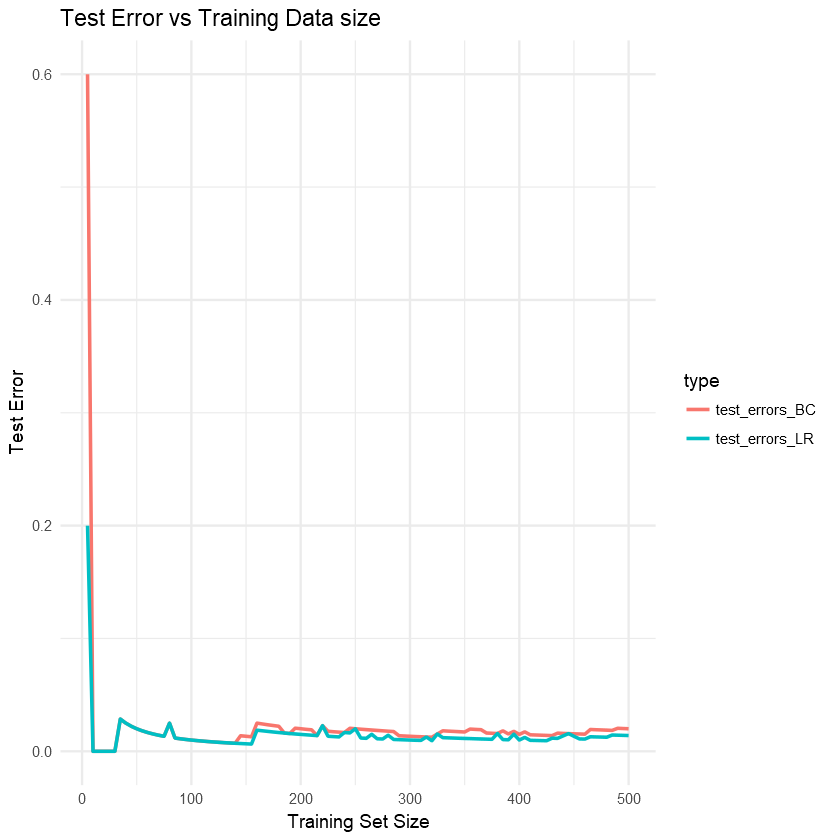

In [13]:
# Plot the test error for each model (with different colors) versus the size of the training set

test_error_melt <- melt(test_error, id='train_set_size')
names(test_error_melt) <- c('train_set_size', 'type','test_error')
ggplot(data=test_error_melt, aes(x = train_set_size, y = test_error, color=type)) + geom_line(size=.75) + 
        labs(title='Test Error vs Training Data size', x = "Training Set Size", y = "Test Error") +  theme_minimal()

## Observations

**What does happen for each classifier when the number of training data points is increased?**
    
At first, the test errors for both bayesian classifier and logistic regression reduces to zero when the training dataset size increases from 5 to 30. The test errors for both the algorithms slightly increases and is equal when the training dataset size increases from 30 to 140. After 140, the test errors slightly increase again and fluctuates for different sizes of training dataset.
       
**Which classifier is best suited when the training set is small, and which is best suited when the training set is big?**
 
From the above plot, we observe that the test error for logistic regression is always less than the bayesian classifier. So, for this given data, logistic regression is suitable for both small and big training sets. This could be different for other data sets. We can infer that bayesian classifier is also suitable for smaller data sets. 

**Possible reasons for the above observations:**

Complex models need large training datasets to fit perfectly. If we try to fit complex model on small data, it would result in overfitting, leading to large variance and thus large test errors. So, for a given model, when we increase size of training data, we can expect a fall in test error.